In [106]:
%pip install --upgrade keras
import keras
print(keras.__version__)

3.1.1


In [107]:
from google.colab import drive
drive.mount('/content/gdrive', readonly=True)

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/ml-project/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/sp-500-stocks

from zipfile import PyZipFile

zipfile = PyZipFile('sp-500-stocks.zip')
zipfile.extractall()

import pandas as pd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
kaggle.json
sp-500-stocks.zip: Skipping, found more recently modified local copy (use --force to force download)


In [108]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [109]:
df_stocks = pd.read_csv('sp500_stocks.csv')
sc = MinMaxScaler(feature_range = (0, 1))
scaler = sc.fit(df_stocks[["Close", "High", "Low", "Open", "Volume"]])
df_stocks[["Close", "High", "Low", "Open", "Volume"]] = scaler.transform(df_stocks[["Close", "High", "Low", "Open", "Volume"]])
print(df_stocks[["Close", "High", "Low", "Open", "Volume"]].shape)
df_stocks.drop(labels=['Adj Close'], axis='columns', inplace=True)
df_stocks.dropna(inplace=True)
df_stocks.set_index('Symbol', inplace=True)
grouped = df_stocks.groupby(level=0)
df_stocks_dict = {group: group_df for group, group_df in grouped}

(1803758, 5)


In [110]:
import numpy as np

numdays = 330
windowSize = 60
features = 5

sc = MinMaxScaler(feature_range = (0, 1))
megaDF = []
sizes = []
i = 0
for key in df_stocks_dict:
    temp_df = df_stocks_dict[key][(-1 * windowSize):].copy()  # Create a copy of the DataFrame
    temp_df.drop(columns=temp_df.columns[0], axis=1, inplace=True)

    if(i == 351) :
      print(temp_df)
    i += 1

    if temp_df.shape[0] == windowSize:  # Check if temp_df has the desired number of rows
        megaDF.append(temp_df.values)  # Append the values to megaDF
        sizes.append(windowSize)  # Update the sizes list
    else:
        print(f"Ignoring {key} due to insufficient data for window calculation")
        continue

mega_array = np.array(megaDF)
print(mega_array.shape)
# mode = max(set(sizes), key=sizes.count)
# print(mode)


Ignoring GEV due to insufficient data for window calculation
           Close      High       Low      Open    Volume
Symbol                                                  
O       0.007257  0.007166  0.007138  0.007067  0.004701
O       0.007234  0.007200  0.007274  0.007217  0.004044
O       0.007212  0.007197  0.007279  0.007274  0.003572
O       0.007232  0.007152  0.007210  0.007197  0.003524
O       0.007186  0.007182  0.007225  0.007265  0.003131
O       0.007117  0.007087  0.007185  0.007154  0.003088
O       0.006977  0.007013  0.006989  0.007039  0.003540
O       0.006843  0.006900  0.006887  0.006973  0.003784
O       0.006892  0.006813  0.006840  0.006867  0.004899
O       0.006776  0.006901  0.006827  0.006907  0.024341
O       0.006827  0.006745  0.006837  0.006805  0.006457
O       0.006703  0.006839  0.006780  0.006910  0.004369
O       0.006756  0.006701  0.006772  0.006780  0.003693
O       0.006701  0.006692  0.006780  0.006778  0.003028
O       0.006694  0.006623 

In [111]:
X_train, y_train, X_valid, y_valid, X_test, y_test = [], [], [], [], [], []

X_train, y_train = mega_array[:int(len(mega_array)*0.7), :windowSize], mega_array[:int(len(mega_array)*0.7), 4]
X_valid, y_valid = mega_array[int(len(mega_array)*0.7):int(len(mega_array)*0.9), :windowSize], mega_array[int(len(mega_array)*0.7):int(len(mega_array)*0.9), 4]
X_test, y_test = mega_array[int(len(mega_array)*0.9):, :windowSize], mega_array[int(len(mega_array)*0.9):, 4]

print(X_train.shape)

(350, 60, 5)


In [112]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True, title="series"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(windowSize, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(windowSize, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.title(title)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [113]:
def plot_learning_curves(loss, val_loss, title):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)

In [114]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(45, return_sequences=True, input_shape=[None, 5]),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(45, return_sequences=True),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(45, return_sequences=False),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(5)
])

model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train, y_train, epochs = 50, batch_size = 32,
                    validation_data=(X_valid, y_valid))
model.save("lstm_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0041 - val_loss: 1.7943e-04
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0013 - val_loss: 2.2017e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 4.2491e-04 - val_loss: 9.2428e-05
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0010 - val_loss: 1.1622e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.4093e-04 - val_loss: 9.0736e-05
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.1004e-04 - val_loss: 1.1407e-04
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.9022e-04 - val_loss: 1.1619e-04
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.1408e-04 - val_loss: 1.0836e-04
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8864e-04 - val_loss: 1.0030e-04
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.8987e-04 - val_loss: 9.7278e-05
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9248e-04 - val_los

In [115]:
print("Evaluation: ")
model.evaluate(X_valid, y_valid)

Evaluation: 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8557e-05 


8.611720841145143e-05

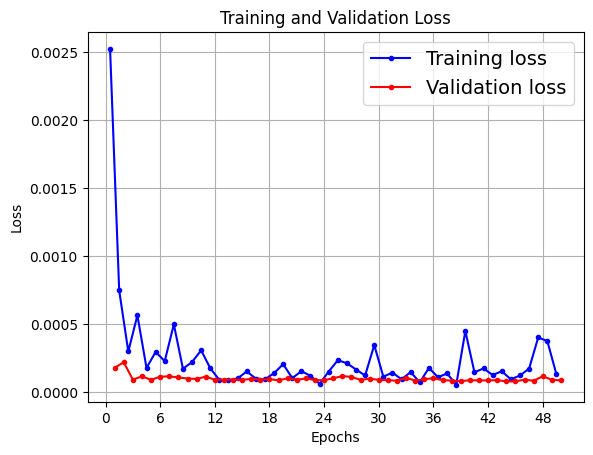

<Figure size 640x480 with 0 Axes>

In [116]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],
                        "Training and Validation Loss")
plt.show()
plt.savefig('loss.png')


(100, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
[4.2565788e+01 4.8445175e+01 2.6686422e+01 5.0050610e+01 4.5076920e+06]


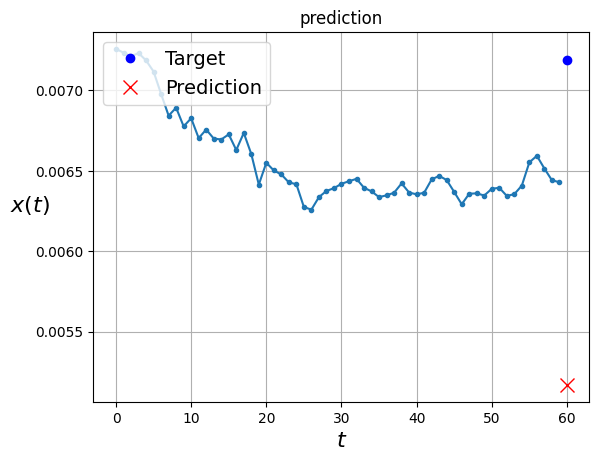

In [117]:
print(X_valid.shape)
test = X_valid[0]
reshaped_arr = test.reshape(1, windowSize, 5)
testPred = model.predict(reshaped_arr)
unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred[0])

plot_series(X_valid[0, :, 0], y_valid[0, 0], testPred[0, 0], title="prediction")